<a href="https://colab.research.google.com/github/DaJaCruz/PhD/blob/main/LSTM_Sequence2One_5points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages

import tensorflow as tf
import pandas as pd # Pandas dataframe (very common in ML)
import numpy as np # import numpy to handle a lot of things!
from tensorflow.keras.models import Sequential
import random
import datetime, os
from keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization#, CuDNNLSTM
import matplotlib.pyplot as plt # import plotting tools to create figures
from IPython.display import display, Math # to print with Latex math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm # to change colors of surface plots
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping



# Uncomment line below if you want to enable live rotation of the surface plots.
#%matplotlib notebook


In [ ]:
%load_ext tensorboard


In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
!apt install cm-super

In [2]:
# Basic plotting tools needed in Python.

#%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
FS = 26  # Font Size
plt.rcParams['axes.facecolor'] = (0.97, 0.97, 0.97)
plt.rcParams['figure.facecolor'] = (1, 1, 1)
plt.rcParams["font.family"] = "sans"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['font.size'] = FS
params = {"ytick.color": (0, 0, 0),
          "xtick.color": (0, 0, 0),
          "grid.color": (.9, .9, .9),
          "text.color": (0, 0, 0),
          "axes.labelcolor": (0, 0, 0),
          "axes.edgecolor": (.15, .15, .15)#,
          #"text.usetex": True
          }
plt.rcParams.update(params)
linewidth=3.0

In [3]:
# import raw data 
url = 'https://raw.githubusercontent.com/DaJaCruz/PhD/main/3PointBendingData_5points_LSTM.csv'
df = pd.read_csv(url, delimiter=';')

In [6]:
# Split raw data in Input (X) and Output (Y) data
X_data_raw = df.loc[:,['Input_P1D','Input_P1F','Input_P2D','Input_P2F','Input_P3D','Input_P3F','Input_P4D','Input_P4F','Input_P5D','Input_P5F']].values
Y_data_raw = df.loc[:,['Output_1','Output_2']].values

# # Multiply the first variable by the second and assign the result to the second variable
# Y_data_raw[:, 1] = Y_data_raw[:, 0] * Y_data_raw[:, 1]

In [7]:
# Reshape data 
X_data_shaped = X_data_raw.reshape((91, 5, 2))
Y_data_shaped = Y_data_raw

In [10]:
#Select the number of cases used 
n_cases = 91
# time_step_1 = 320
# time_step_2 = 380
n_timesteps = 5
total_n_points= n_cases*n_timesteps
X_data = X_data_shaped[:n_cases, :, :]
Y_data = Y_data_shaped[:n_cases, :]

In [12]:
#Reshape X_data and Y_data to Normalization operation
X_data_reshaped_norm=X_data.reshape(total_n_points, 2)
Y_data_reshaped_norm=Y_data

In [13]:
#
#Scale Inputs with a [-1,1] scaler
scaler_x = MinMaxScaler(feature_range=(-1,1))
#
# Scaling inputs with a Standard Scaler:
#scaler_x = StandardScaler()
#
scaler_x.fit(X_data_reshaped_norm)# fit the scaler to the input data
#
X_data_scaled_shaped=scaler_x.transform(X_data_reshaped_norm) # scale the input data (the whole dataset)
#
#Scale Inputs with a [-1,1] scaler
scaler_y = MinMaxScaler(feature_range=(-1,1))
#
# Scaling inputs with a Standard Scaler:
#scaler_y = StandardScaler()
#
scaler_y.fit(Y_data_reshaped_norm) # fit the scaler to the output data
Y_data_scaled_shaped=scaler_y.transform(Y_data_reshaped_norm) # scale the output data (the whole dataset)

In [14]:
# Reshape data 
X_data_scaled = X_data_scaled_shaped.reshape((n_cases, n_timesteps, 2))
Y_data_scaled = Y_data_scaled_shaped

In [ ]:
print('X_data =', X_data)
# print('Y_data =', Y_data)
# print('X_data_scaled =', X_data_scaled.shape)
# print('Y_data_Scaled =', Y_data_scaled)

Text(0.5, 1.0, 'Normalized output data')

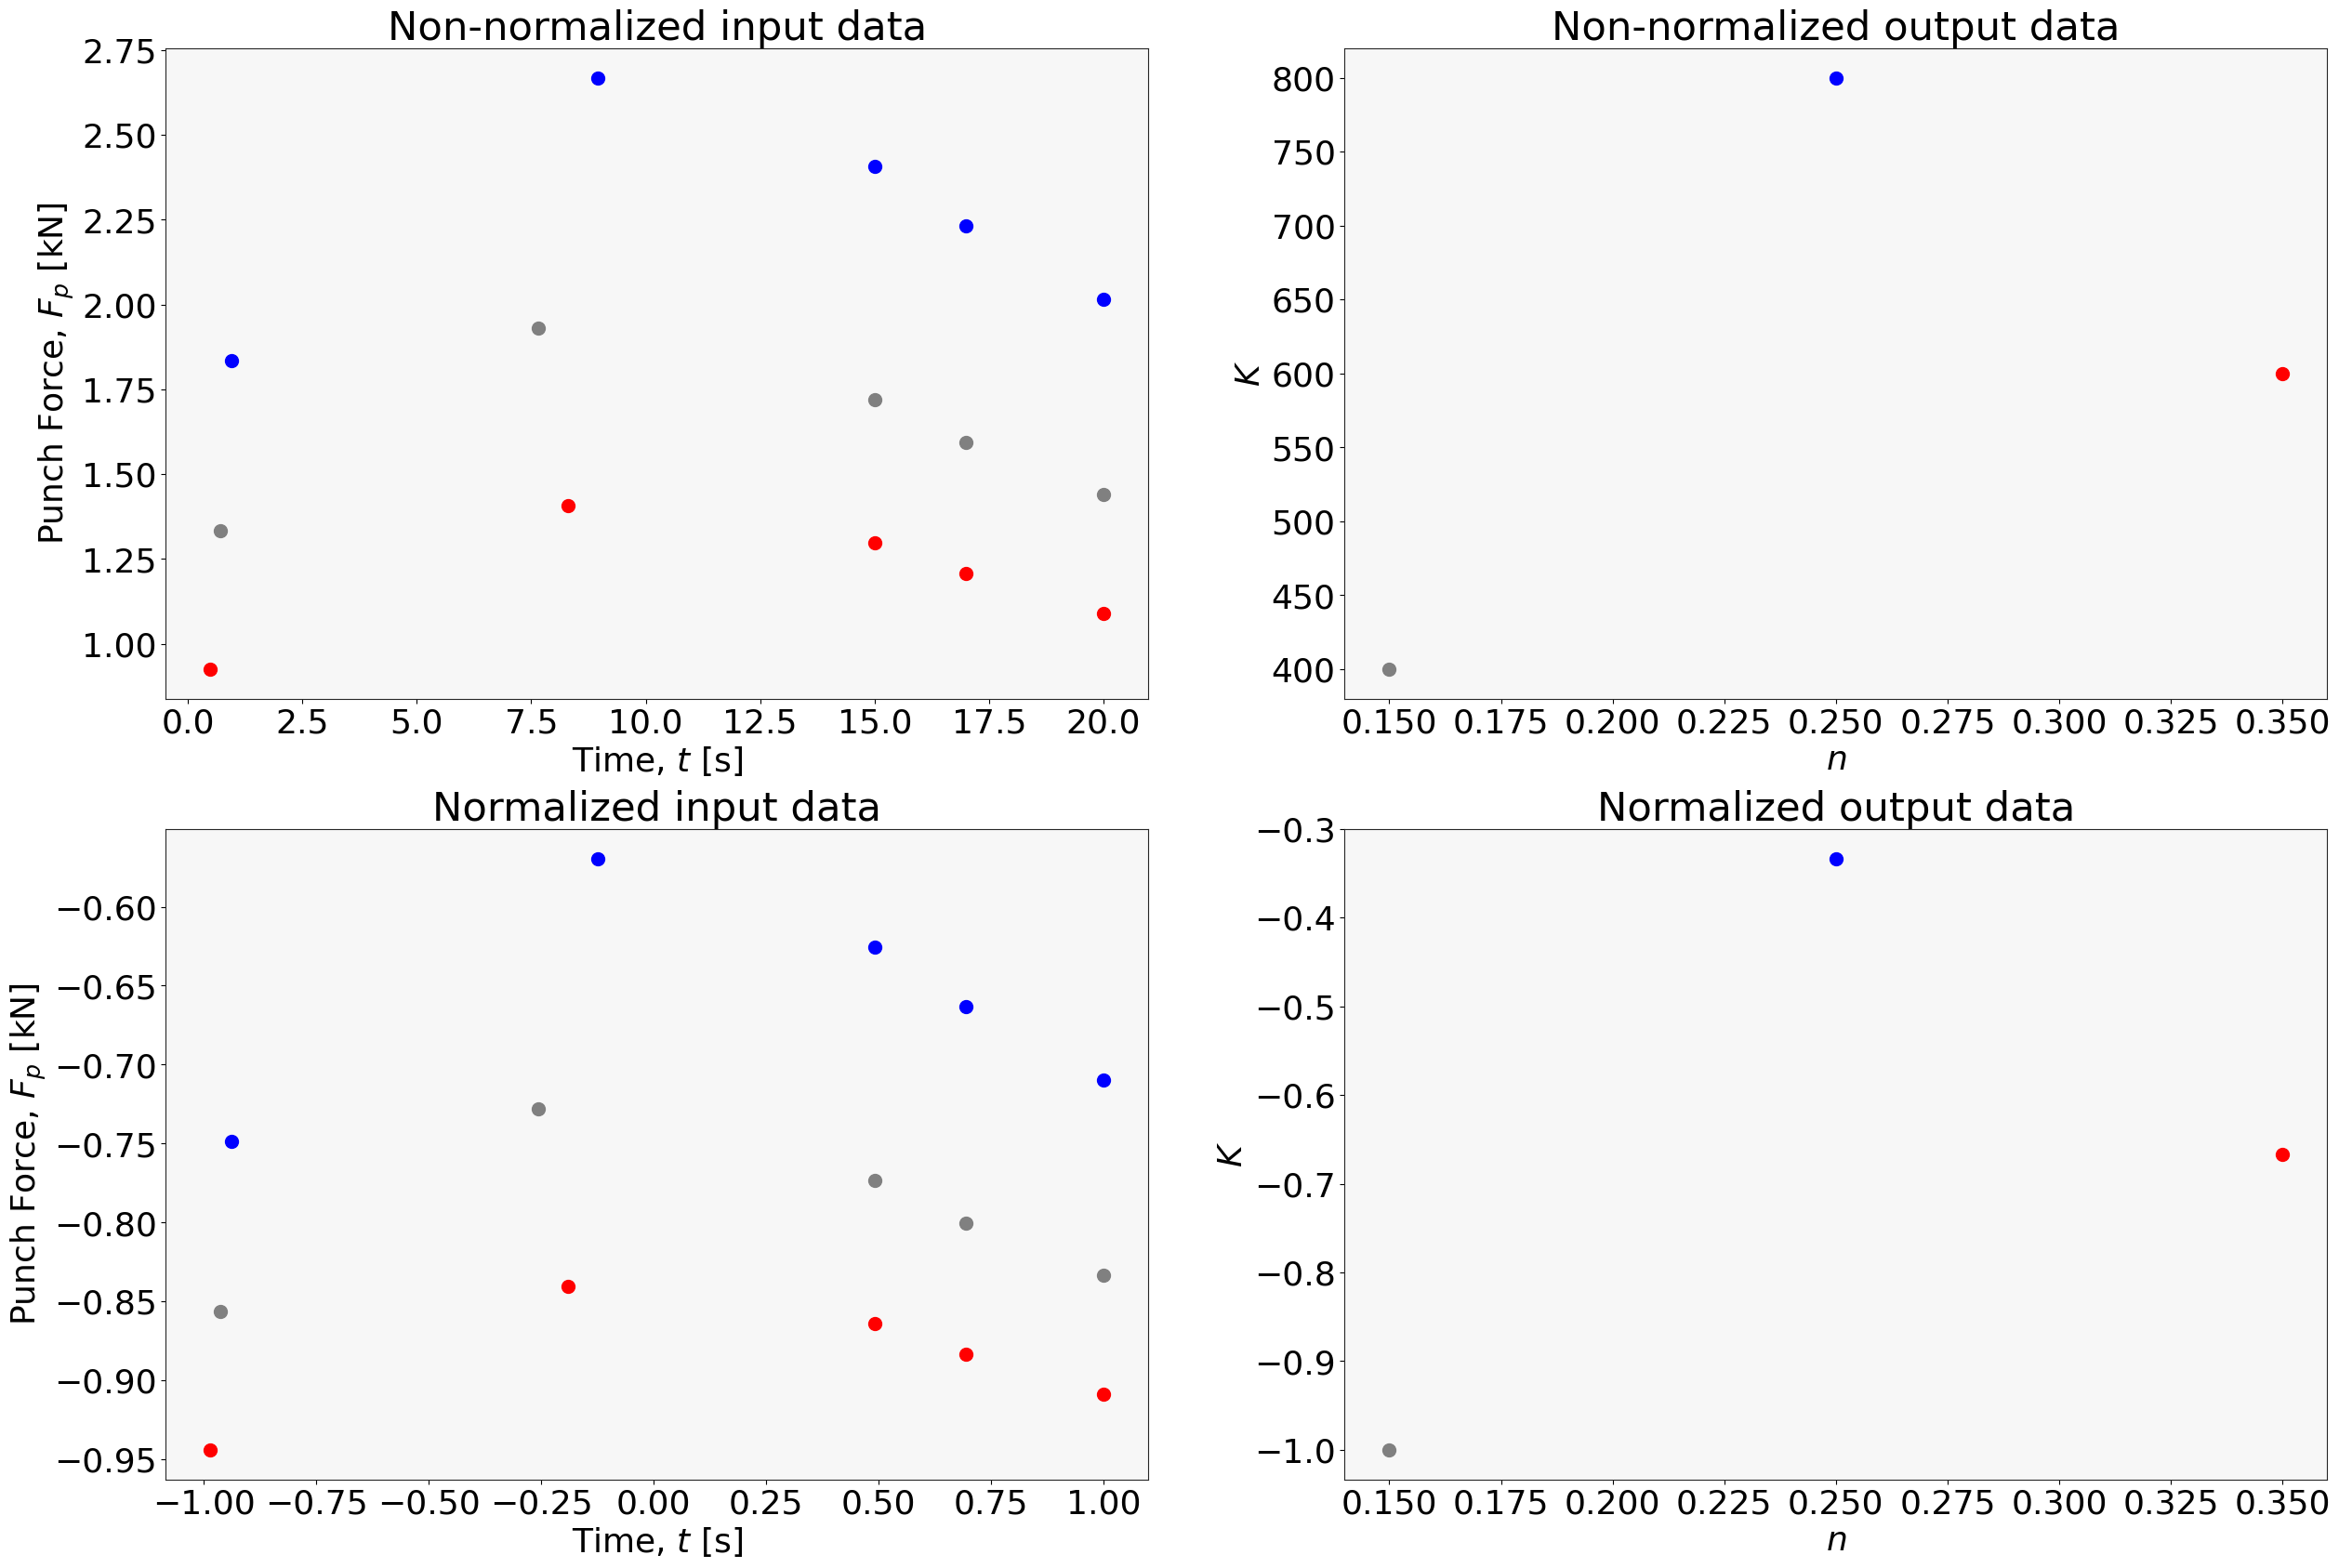

In [17]:
#Plots with normalized and Non-normalized inputs
fig_ANN, ((ax1_ANN, ax2_ANN), (ax3_ANN, ax4_ANN)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

#Case Studies to represent
Case_1 = 3
Case_2 = 20
Case_3 = 50

#Force Displacement Curves
ax1_ANN.plot(X_data[Case_1,:,0], X_data[Case_1,:,1], 'o', markersize=10, color='blue', label="training points") # show Non-normalized training data
ax1_ANN.plot(X_data[Case_2,:,0], X_data[Case_2,:,1], 'o', markersize=10, color='gray', label="training points") # show Non-normalized training data
ax1_ANN.plot(X_data[Case_3,:,0], X_data[Case_3,:,1], 'o', markersize=10, color='red', label="training points") # show Non-normalized training data
ax1_ANN.set_ylabel('Punch Force, $F_p$ [kN]')
ax1_ANN.set_xlabel('Time, $t$ [s]')
ax1_ANN.set_title('Non-normalized input data')
#ax1_ANN.legen#d(['training', 'testing', 'validation' ], loc='best')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax1_ANN.set_ylim([0, 10])
# ax1_ANN.set_xlim([0, 20])

# K-n Points
ax2_ANN.plot(Y_data[Case_1,1], Y_data[Case_1,0], 'o', markersize=10, color='blue') # show normalized training data
ax2_ANN.plot(Y_data[Case_2,1], Y_data[Case_2,0], 'o', markersize=10, color='gray') # show normalized training data
ax2_ANN.plot(Y_data[Case_3,1], Y_data[Case_3,0], 'o', markersize=10, color='red') # show normalized training data
ax2_ANN.set_ylabel('$K$')
ax2_ANN.set_xlabel('$n$')
ax2_ANN.set_title('Non-normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax2_ANN.set_ylim([200, 1800])
# ax2_ANN.set_xlim([0, 0.4])

ax3_ANN.plot(X_data_scaled[Case_1,:,0], X_data_scaled[Case_1,:,1], 'o', markersize=10, color='blue', label="training points") # show Non-normalized training data
ax3_ANN.plot(X_data_scaled[Case_2,:,0], X_data_scaled[Case_2,:,1], 'o', markersize=10, color='gray', label="training points") # show Non-normalized training data
ax3_ANN.plot(X_data_scaled[Case_3,:,0], X_data_scaled[Case_3,:,1], 'o', markersize=10, color='red', label="training points") # show Non-normalized training data
ax3_ANN.set_ylabel('Punch Force, $F_p$ [kN]')
ax3_ANN.set_xlabel('Time, $t$ [s]')
ax3_ANN.set_title('Normalized input data')
#ax1_ANN.legen#d(['training', 'testing', 'validation' ], loc='best')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax3_ANN.set_ylim([-1, 1])
# ax3_ANN.set_xlim([-1, 1])

# K-n Points
ax4_ANN.plot(Y_data[Case_1,1], Y_data_scaled[Case_1,0], 'o', markersize=10, color='blue') # show normalized training data
ax4_ANN.plot(Y_data[Case_2,1], Y_data_scaled[Case_2,0], 'o', markersize=10, color='gray') # show normalized training data
ax4_ANN.plot(Y_data[Case_3,1], Y_data_scaled[Case_3,0], 'o', markersize=10, color='red') # show normalized training data
ax4_ANN.set_ylabel('$K$')
ax4_ANN.set_xlabel('$n$')
ax4_ANN.set_title('Normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax4_ANN.set_ylim([-1.25, 1.25])
# ax4_ANN.set_xlim([-1.25, 1.25])


# Create figure with specified size
# fig_ANN.set_size_inches(22, 10)

In [19]:
# Divide datasets into train and test 

X_val = X_data[0:36,:] # Validation/Testing input dataset
X_train = X_data[36:91,:] # Training input dataset
X_val_scaled = X_data_scaled[0:36,:] # Validation/Testing input dataset
X_train_scaled = X_data_scaled[36:91,:] # Training input dataset
#
Y_val= Y_data[0:36,:] # Validation/Testing output dataset
Y_train = Y_data[36:91,:] # Training output dataset
Y_val_scaled= Y_data_scaled[0:36,:] # Validation/Testing output dataset
Y_train_scaled = Y_data_scaled[36:91,:] # Training output dataset

Text(0.5, 1.0, 'Normalized output data')

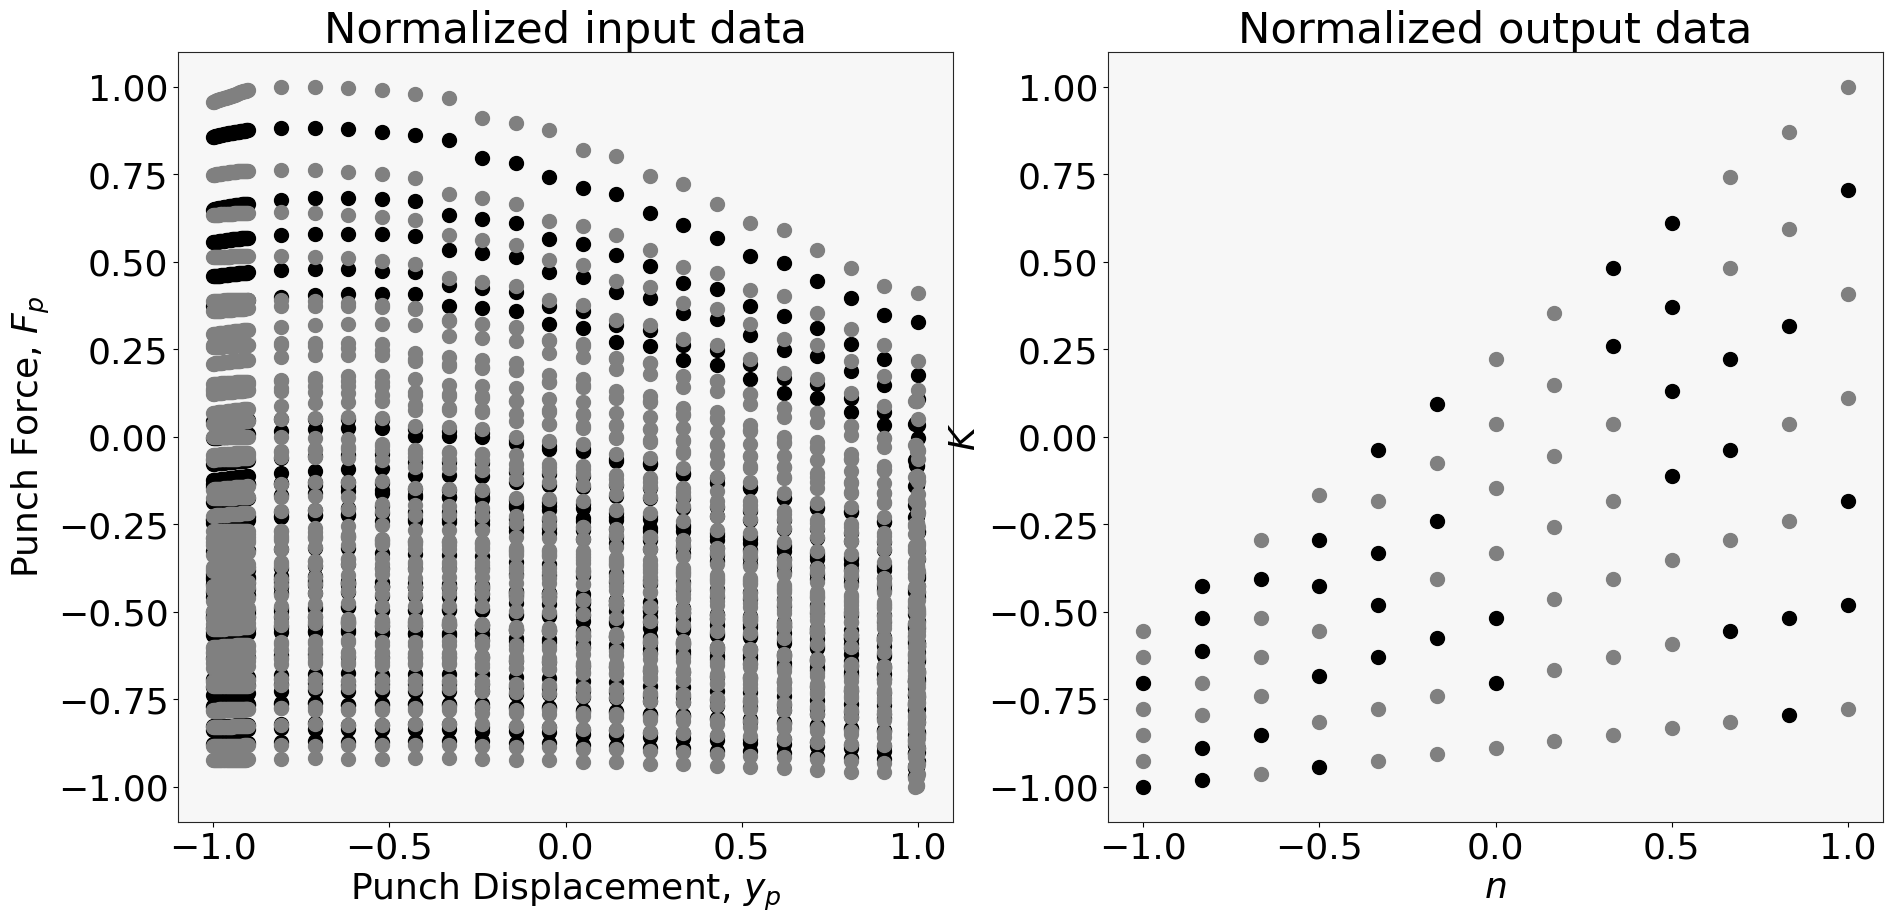

In [ ]:
#Plots with normalized and Non-normalized outputs
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)

cases = np.arange(1, n_cases+1, 1)

ax1_ANN.plot(X_test_scaled[:,:,0], X_test_scaled[:,:,1], 'o', markersize=10, color='black', label="testing points") # show normalized training data
ax1_ANN.plot(X_train_scaled[:,:,0], X_train_scaled[:,:,1], 'o', markersize=10, color='gray', label="training points") # show normalized training data
ax1_ANN.set_ylabel('Punch Force, $F_p$')
ax1_ANN.set_xlabel('Punch Displacement, $y_p$')
ax1_ANN.set_title('Normalized input data')
# ax1_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax1_ANN.set_ylim([-1.25, 1.25])
# ax1_ANN.set_xlim([-1.25, 1.25])
# Create figure with specified size
fig_ANN.set_size_inches(22, 10)

# K-n Points
ax2_ANN.plot(Y_test_scaled[:,0], Y_test_scaled[:,1], 'o', markersize=10, color='black') # show normalized training data
ax2_ANN.plot(Y_train_scaled[:,0], Y_train_scaled[:,1], 'o', markersize=10, color='gray') # show normalized training data
# ax2_ANN.plot(cases, Y_test_scaled, 'o', markersize=10, color='black', label="testing points") # show normalized training data
ax2_ANN.set_ylabel('$K$')
ax2_ANN.set_xlabel('$n$')
ax2_ANN.set_title('Normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax2_ANN.set_ylim([-1.25, 1.25])
# ax2_ANN.set_xlim([-1.25, 1.25])


In [ ]:
_, idx = np.unique(Y_data_raw, axis=0, return_index=True)
Y_data_unique_sorted = Y_data_raw[np.sort(idx)]
Y_dat_unique = Y_data_unique_sorted[:, 0].reshape(-1, 1)
# print(Y_dat_unique, Y_data_unique_sorted)


In [ ]:
# Build the Bidirectional LSTM model
model = Sequential()
model.add(LSTM(50,
               activation = 'tanh', # Activation function to use.
               recurrent_activation = 'sigmoid', # Activation function to use for the recurrent step
               use_bias = True, 
               kernel_initializer = 'glorot_uniform', # Initializer for the kernel weights matrix, 
               recurrent_initializer = 'orthogonal', # Initializer for the reccurent_kernel weights matrix
               bias_initializer = 'zeros', # Initializer for the bias vector
               unit_forget_bias = True, # If true, add 1 to the bias of the forget gate at initialization
               kernel_regularizer = None, # Regularizer function applied to the kernel weights
               recurrent_regularizer = None, # Relularizer function applied to the recurrent weights
               bias_regularizer = None, # Regularizer function applied to the bias vector
               activity_regularizer = None, # Regularizer function applied to the output of each LSTM layer
               kernel_constraint = None, # Constraint function applied to the kernel weights
               recurrent_constraint = None, # Constraint function applied to the recurrent_kernel weights matrix
               bias_constraint = None, # Constraint function applied to the bias vector
               dropout = 0.0, # Fraction of the units to drop for the linear transformation of the inputs
               recurrent_dropout = 0.0, # Fraction of the units to drop for the linear transformation of the recurrent state.
               return_sequences=False, # Whether to return the last output in the output sequence, or the full sequence
               return_state=False, # Whether to return the last state in addition to the output. 
               go_backwards=False, # If True, process the input sequence backwards and return the reversed sequence.
               stateful=False, #  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
               time_major=False, # If True, the inputs and outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature].
               unroll=False, #  If True, the network will be unrolled
               input_shape = (n_timesteps, 2),
               ))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(50)))
# model.add(Dropout(0.2))
model.add(Dense(5, activation = "tanh"))
model.add(Dense(2, activation = "linear"))
model.compile()

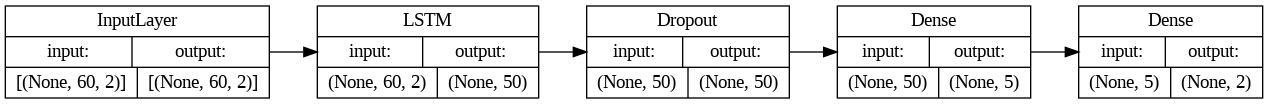

In [ ]:
# Vizualize the model architecture
plot_model(model, to_file='model.png', 
           show_shapes=True, # Display the shapes of the input and output tensors
           show_dtype = False, # Display layer data type
           show_layer_names= False, # Display the name of the layer
           rankdir = 'LR'  # Control the orientation of the diagram (LR or TB)
           )

In [ ]:
# Compile the model
# Define the learning rate schedule
initial_learning_rate = 0.01
decay_steps = 2
decay_rate = 0
learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='max',patience=5000)

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',
              optimizer=opt, metrics=['accuracy']) 

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Train the model with the optimizer
history = model.fit(X_train_scaled, Y_train_scaled, 
                    validation_data=(X_test_scaled, Y_test_scaled), 
                    epochs=2000,
                    callbacks=[tensorboard_callback, earlyStop])

Epoch 1/2000
2/2 [==============================] - 4s 618ms/step - loss: 0.4438 - accuracy: 0.5000 - val_loss: 0.3743 - val_accuracy: 0.9459
Epoch 2/2000
2/2 [==============================] - 0s 95ms/step - loss: 0.3730 - accuracy: 0.6481 - val_loss: 0.3271 - val_accuracy: 0.7027
Epoch 3/2000
2/2 [==============================] - 0s 96ms/step - loss: 0.3214 - accuracy: 0.6852 - val_loss: 0.3006 - val_accuracy: 0.7027
Epoch 4/2000
2/2 [==============================] - 0s 104ms/step - loss: 0.3023 - accuracy: 0.6481 - val_loss: 0.2911 - val_accuracy: 0.7027
Epoch 5/2000
2/2 [==============================] - 0s 107ms/step - loss: 0.2907 - accuracy: 0.6667 - val_loss: 0.2912 - val_accuracy: 0.7027
Epoch 6/2000
2/2 [==============================] - 0s 99ms/step - loss: 0.2980 - accuracy: 0.6667 - val_loss: 0.2929 - val_accuracy: 0.7027
Epoch 7/2000
2/2 [==============================] - 0s 107ms/step - loss: 0.2956 - accuracy: 0.6667 - val_loss: 0.2906 - val_accuracy: 0.7027
Epoch 8/2

In [ ]:
# print the shapes of the weight matrices
weights = model.layers[0].get_weights()
for i in range(len(weights)):
    print(f"Shape of layer {i} weights: {weights[i].shape}")

Shape of layer 0 weights: (2, 120)
Shape of layer 1 weights: (30, 120)
Shape of layer 2 weights: (120,)


In [ ]:
# Save the weights of the model at a specific epoch
#model.save_weights('checkpoint_epoch_50')

# Load the saved weights at epoch 5
# model.load_weights('checkpoint_epoch_50')


# Use the model for prediction on new data
# y_pred = model.predict(x_test)

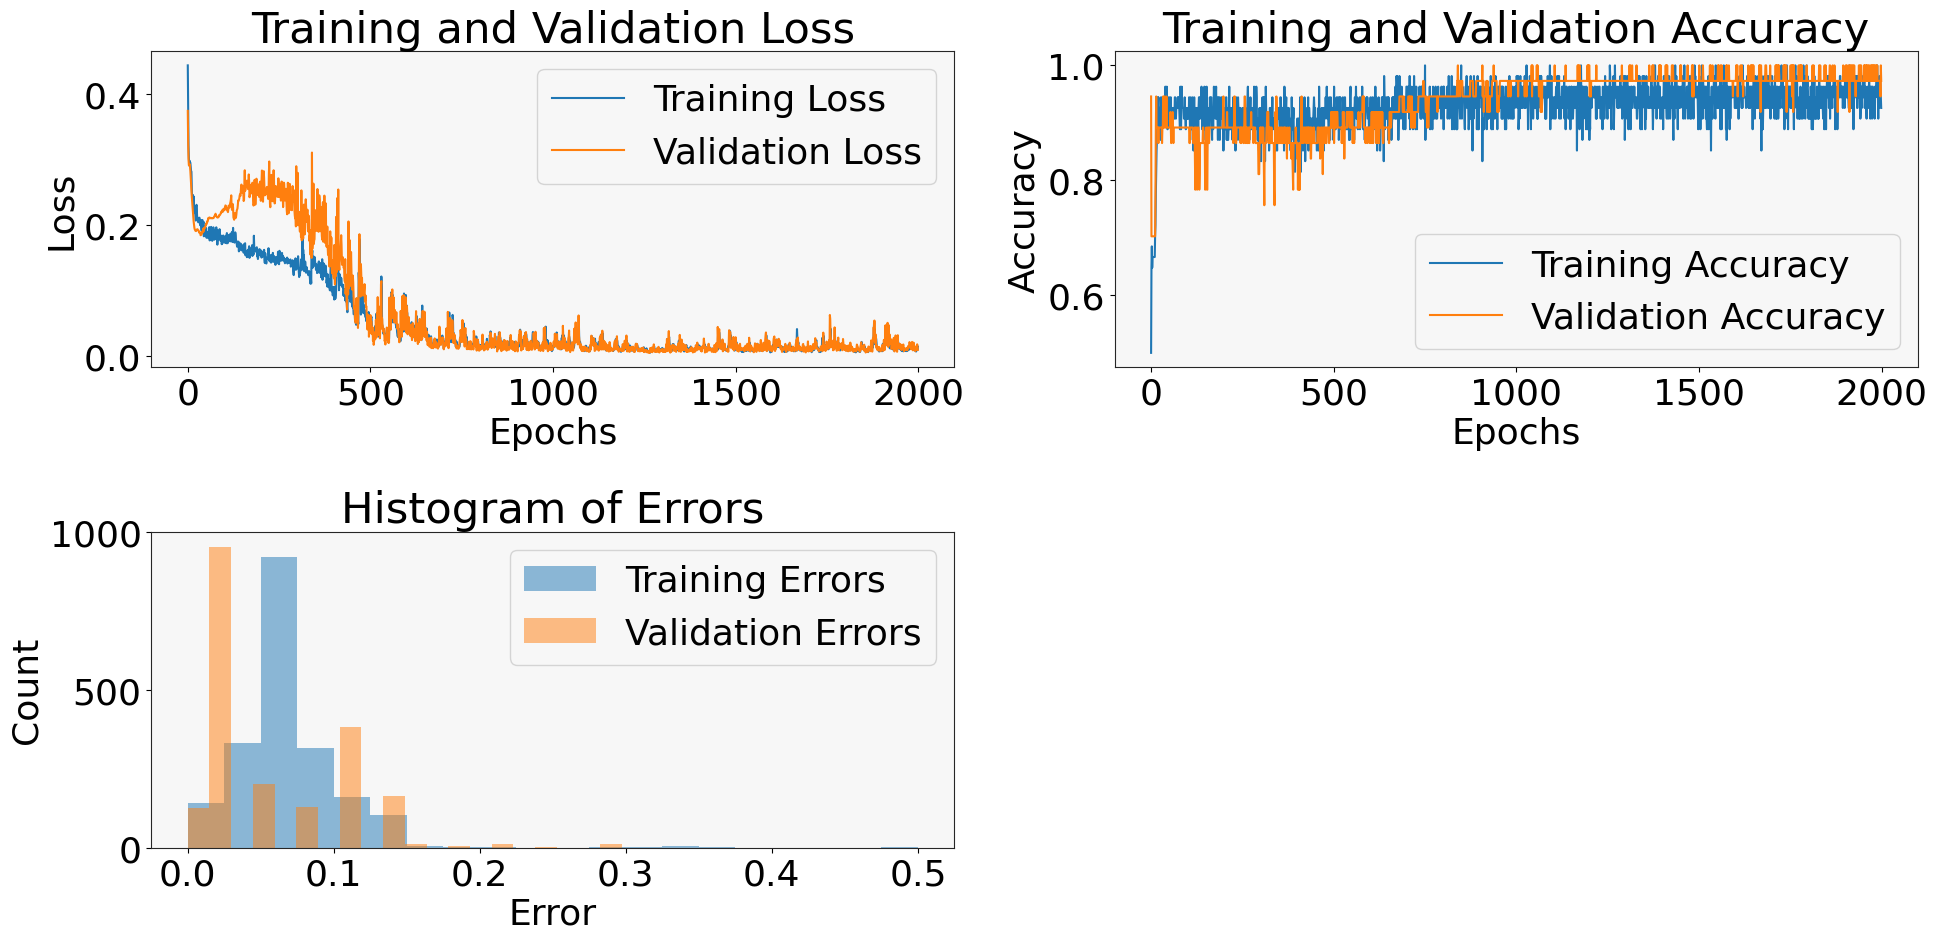

In [ ]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]

# plot the training and validation loss on the first subplot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# plot the training and validation accuracy on the second subplot
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# plot a histogram of the errors on a third subplot
errors = [1-acc for acc in history.history['accuracy']]
val_errors = [1-acc for acc in history.history['val_accuracy']]
ax3.hist(errors, bins=20, alpha=0.5, label='Training Errors')
ax3.hist(val_errors, bins=20, alpha=0.5, label='Validation Errors')
ax3.set_xlabel('Error')
ax3.set_ylabel('Count')
ax3.set_title('Histogram of Errors')
ax3.legend()

# remove the unused subplot
fig.delaxes(axes[1, 1])

# adjust the layout and display the figure
fig.tight_layout()
plt.show()

In [ ]:
Y_data_ANNpred_scaled = model.predict(X_data_scaled)
Y_data_ANNpred = scaler_y.inverse_transform(Y_data_ANNpred_scaled)
Y_data_ANNpred_scaled = Y_data_ANNpred_scaled.reshape(n_cases,2)
Y_data_ANNpred = Y_data_ANNpred.reshape(n_cases,2)

print(Y_data_ANNpred_scaled.shape)

3/3 [==============================] - 0s 5ms/step
(91, 2)


In [ ]:
%tensorboard --logdir logs

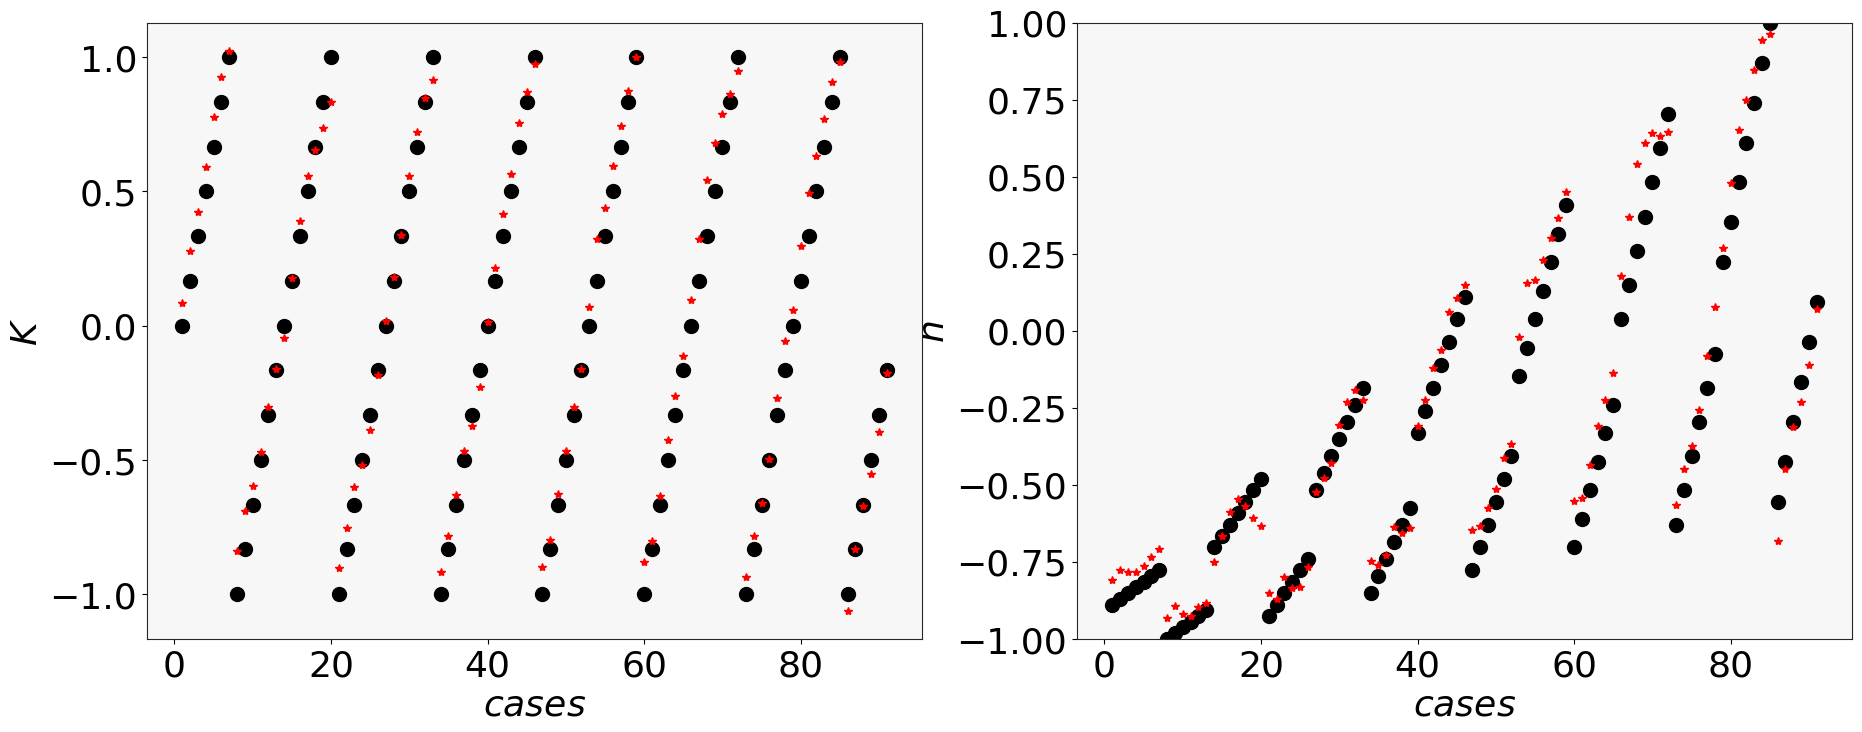

In [ ]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)

cases = np.arange(1, n_cases+1, 1)
ax1_ANN.plot(cases, Y_data_scaled[:,0], 'o', markersize=10, color='black', label="testing points") # show training data
ax1_ANN.plot(cases, Y_data_ANNpred_scaled[:,0], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
ax1_ANN.set_ylabel('$K$')
ax1_ANN.set_xlabel('$cases$')


ax2_ANN.plot(cases, Y_data_scaled[:,1], 'o', markersize=10, color='black', label="testing points") # show training data
ax2_ANN.plot(cases, Y_data_ANNpred_scaled[:,1], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
ax2_ANN.set_ylabel('$n$')
ax2_ANN.set_xlabel('$cases$')
# ax2_ANN.set_xlim([-1, 1])
ax2_ANN.set_ylim([-1, 1])

# ax2_ANN.plot(Y_data[:,1,:], Y_data[:,0,:], 'o', markersize=10, color='gray', label="training points") # show training data
# ax2_ANN.plot(Y_data_ANNpred[:,1], Y_data_ANNpred[:,0], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
# ax2_ANN.set_ylabel('$K$')
# ax2_ANN.set_xlabel('$n$')
# # ax2_ANN.legend(loc='best')
# ax2_ANN.set_xlim([0, 0.4])
# ax2_ANN.set_ylim([200, 1800])
#ax2_ANN.grid(True, color='gray', linestyle='-')
# Create figure with specified size
fig_ANN.set_size_inches(22, 8)

(0.0, 1.0)

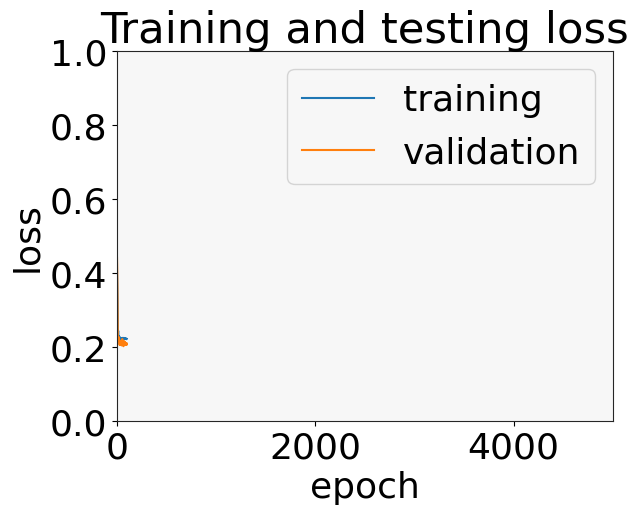

In [ ]:
fig_ANN, (ax1_ANN) = plt.subplots(1,1)

ax1_ANN.plot(history.history['loss'])
ax1_ANN.plot(history.history['val_loss'])
ax1_ANN.set_title('Training and testing loss')
ax1_ANN.set_ylabel('loss')
ax1_ANN.set_xlabel('epoch')
ax1_ANN.legend(['training', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
ax1_ANN.set_xlim([0, 5000])
ax1_ANN.set_ylim([0, 1])